<a href="https://colab.research.google.com/github/orhanaydinn/brainTumor_Alzheimer_Prediction/blob/main/BrainTumor_Alzheimer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1 - Uploaded Dataset**

tumor_alzheimer_dataset.zip file upload manually.
```
zip_path = "/content/tumor_alzheimer_dataset.zip"
extract_path = "/content/tumor_alzheimer_dataset"
```
**zip_path** represents the file path of the uploaded ZIP file.

**extract_path** defines the destination directory where the contents of the ZIP file will be extracted.

In [1]:
import zipfile
import os

# File and directory paths to extract
zip_path = "/content/tumor_alzheimer_dataset.zip"
extract_path = "/content/tumor_alzheimer_dataset"

# Open zip file and extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset successfully extracted to:", extract_path)


Dataset successfully extracted to: /content/tumor_alzheimer_dataset


Check the loaded datasets before data preparation process.

**`os.walk(extract_path)`** Examines the entire structure of the specified folder, including its subfolders.

**`root`** The full path of the currently browsed directory.

**`dirs`** list of folders in that directory.

**`files`** list of files in that directory.



In [2]:
for root, dirs, files in os.walk(extract_path):
    print(f"\n📂 {root}")
    for d in dirs:
        print(f"├── 📁 {d}")
    for f in files[:5]:
        print(f"├── 📄 {f}")


📂 /content/tumor_alzheimer_dataset
├── 📁 tumor_alzheimer_dataset

📂 /content/tumor_alzheimer_dataset/tumor_alzheimer_dataset
├── 📁 alzheimer_non_demented
├── 📁 tumor_yes
├── 📁 alzheimer_moderate_demented
├── 📁 tumor_no
├── 📁 alzheimer_mild_demented
├── 📁 alzheimer_very_mild_demented

📂 /content/tumor_alzheimer_dataset/tumor_alzheimer_dataset/alzheimer_non_demented
├── 📄 non_demented_2433.jpg
├── 📄 non_demented_8085.jpg
├── 📄 non_demented_4641.jpg
├── 📄 non_demented_12683.jpg
├── 📄 non_demented_8421.jpg

📂 /content/tumor_alzheimer_dataset/tumor_alzheimer_dataset/tumor_yes
├── 📄 tumor_yes_5319.jpg
├── 📄 tumor_yes_349.jpg
├── 📄 tumor_yes_6223.jpg
├── 📄 tumor_yes_5822.jpg
├── 📄 tumor_yes_556.jpg

📂 /content/tumor_alzheimer_dataset/tumor_alzheimer_dataset/alzheimer_moderate_demented
├── 📄 moderate_4266.jpg
├── 📄 moderate_4559.jpg
├── 📄 moderate_1559.jpg
├── 📄 moderate_2295.jpg
├── 📄 moderate_1008.jpg

📂 /content/tumor_alzheimer_dataset/tumor_alzheimer_dataset/tumor_no
├── 📄 tumor_no_1015.j

**` def show_random_images(dataset_dir, samples=3):`**
This function displays a random 3 sample images from each class.

**`img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)`**
cv2 library create BGR images default setting. This code convert BGR to RGB.



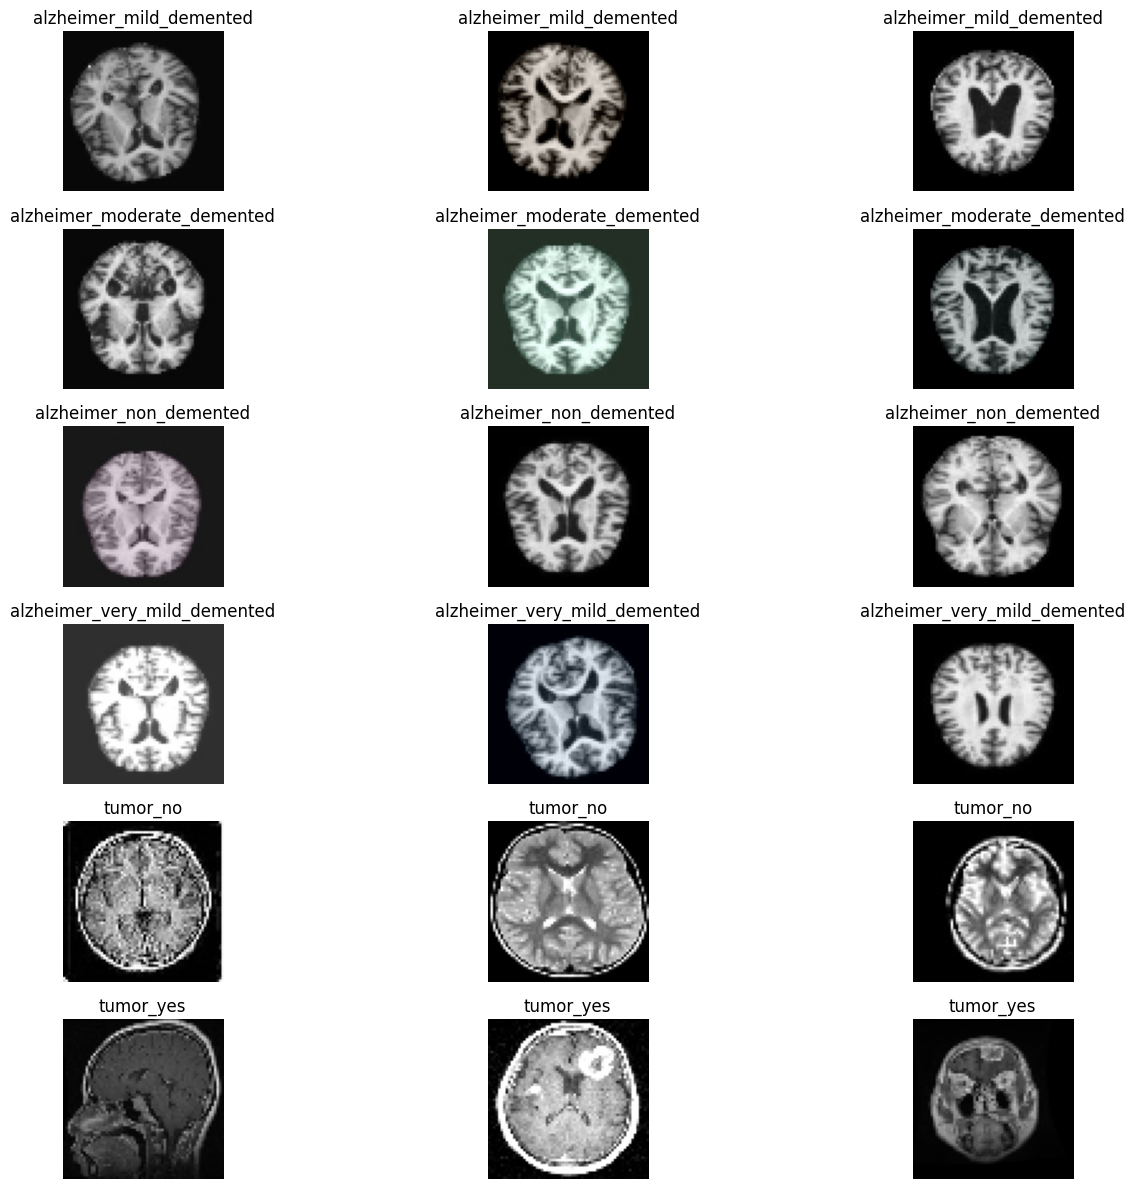

In [20]:
import matplotlib.pyplot as plt
import cv2
import random

IMG_SIZE = 64
DATASET_DIR = "/content/tumor_alzheimer_dataset/tumor_alzheimer_dataset"

# Show random 3 images all the class
def show_random_images(dataset_dir, samples=3):
    class_folders = [f for f in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, f))]

    plt.figure(figsize=(15, len(class_folders) * 2))
    i = 1
    for label in sorted(class_folders):
        class_path = os.path.join(dataset_dir, label)
        images = os.listdir(class_path)
        random.shuffle(images)

        for img_name in images[:samples]:
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            plt.subplot(len(class_folders), samples, i)
            plt.imshow(img)
            plt.title(label)
            plt.axis('off')
            i += 1
    plt.tight_layout()
    plt.show()

show_random_images(DATASET_DIR)

# **2 - Data Preparation & Preprocessing**

In this section, the data was examined and augmentation was applied to some labels.

*   Load and Label Data
*   Read, Resize and Convert Images to Arrays
*   Convert to Numpy Arrays and Normalize the Pixel Values
*   Data Augmentation
    *   Class Distribution Table
    *   Augmentation for **tumor_no** labels
        *   Show Augmentation Images
    *   Augmentation for **tumor_yes** labels
        *   Show Augmentation Images
*   Shor Current Dataset




## 2.1 - Load and Label Data

**`label_map = {label: idx for idx, label in enumerate(class_names)}`**

This code automatically detects the class folders in the dataset directory and maps each class to a unique integer.

In [4]:
import os


DATASET_DIR = "/content/tumor_alzheimer_dataset/tumor_alzheimer_dataset"

# Sınıf isimlerini al ve etiketle
class_names = sorted(os.listdir(DATASET_DIR))
label_map = {label: idx for idx, label in enumerate(class_names)}
print("Label Mapping:", label_map)

Label Mapping: {'alzheimer_mild_demented': 0, 'alzheimer_moderate_demented': 1, 'alzheimer_non_demented': 2, 'alzheimer_very_mild_demented': 3, 'tumor_no': 4, 'tumor_yes': 5}


## 2.2 - Read, Resize and Convert Images to Arrays

In this project image size is used 64x64 (`IMG_SIZE = 64`) . Therefore, this code `img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))` resize all of images which are differents size.

In [5]:
import cv2
import numpy as np
from tqdm import tqdm

IMG_SIZE = 64  # Görselleri boyutlandıracağımız hedef boyut
X = []          # Image Data
y = []          # Labels


for class_name in class_names:
    class_path = os.path.join(DATASET_DIR, class_name)
    label = label_map[class_name]

    for img_name in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
        img_path = os.path.join(class_path, img_name)

        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # resize

            X.append(img)
            y.append(label)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")


Processing tumor_yes: 100%|██████████| 6679/6679 [00:13<00:00, 504.22it/s]


## 2.3 - Convert to NumPy Arrays & Normalize the Pixel Values

This code block makes the data types available for model training and normalizes the pixel values ​​of the images.

```
X = np.array(X, dtype='float32')
y = np.array(y)
```
Converts the Python lists X and y into NumPy arrays.

`X /= 255.0` It reduces the pixel values ​​from the range of 0-255 to the range of 0-1. This process allows the model to learn faster and more stably.

In [6]:
# Convert lists to NumPy arrays
X = np.array(X, dtype='float32')
y = np.array(y)

# Normalize pixel values to range [0, 1]
X /= 255.0

print("Data converted to NumPy arrays.")
print("X shape:", X.shape)
print("y shape:", y.shape)

Data converted to NumPy arrays.
X shape: (50661, 64, 64, 3)
y shape: (50661,)


## 2.4 - Data Augmentation

### 2.4.1 -  Class Distribution Table

Before the data augmentation, dataset was controlled anc created table which are include label, label name, image count.

In [7]:
import pandas as pd
from collections import Counter


label_counts = Counter(y)
reverse_label_map = {v: k for k, v in label_map.items()}


class_distribution_df = pd.DataFrame({
    'Label Index': list(label_counts.keys()),
    'Label Name': [reverse_label_map[i] for i in label_counts.keys()],
    'Image Count': list(label_counts.values())
})


class_distribution_df = class_distribution_df.sort_values(by='Image Count', ascending=False)
display(class_distribution_df)


,Label Index,Label Name,Image Count
2,2,alzheimer_non_demented,12800
3,3,alzheimer_very_mild_demented,11200
0,0,alzheimer_mild_demented,9856
5,5,tumor_yes,6679
1,1,alzheimer_moderate_demented,6528
4,4,tumor_no,3598


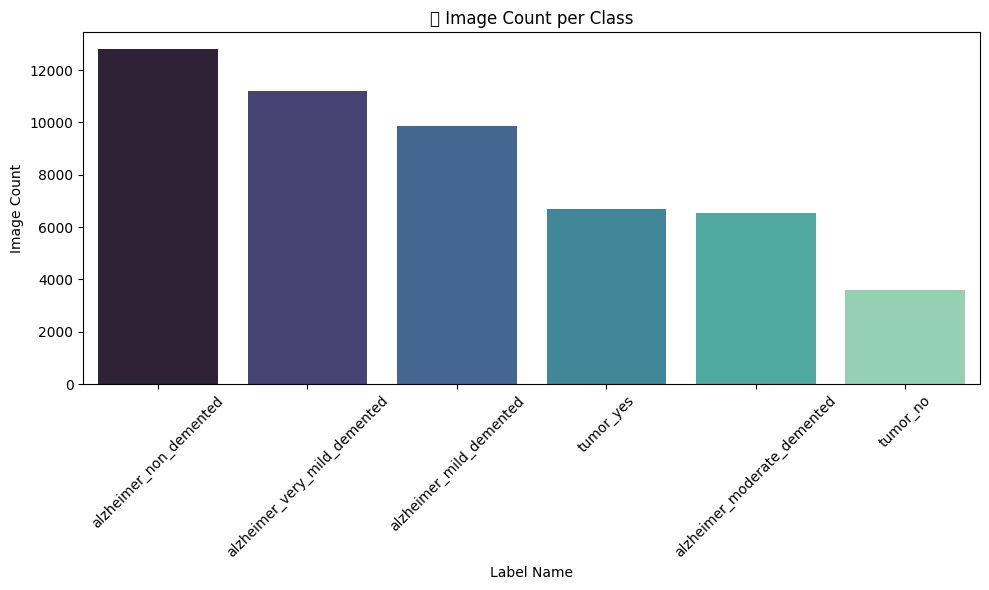

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings


warnings.filterwarnings("ignore")

plt.figure(figsize=(10, 6))
sns.barplot(data=class_distribution_df, x="Label Name", y="Image Count", palette="mako")
plt.title("📊 Image Count per Class")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This dataset has enough images for classification problem **alzheimer**. However, the **tumor_yes** and **tumor_no** classes have significantly fewer samples compared to the others, which can lead to class unbalance and potential overfitting issues. Therefore augmention was applied just two labels.

### 2.4.2 - Tumor_NO Augmentation

`target_count = 9000` The target number of images was determined as 9000 and the current number of images was subtracted from this number `to_generate = target_count - current_count`.

`for img_name in tqdm(existing_images):` This function generated the required number of images.

```
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)
```


*   Every images was rotated 15°. `rotation_range=15`
*   Zoomed by 10% `zoom_range=0.1`.
*   Slightly shifted horizontally and vertically `width_shift_range=0.1,
height_shift_range=0.1`.
*   Brightness was adjusted between 80% and 120%. `brightness_range=[0.8,1.2]`
*   Some images were flipped horizontally. Empty areas were filled using the nearest pixel method. `horizontal_flip=True, fill_mode='nearest'`


` aug_name = f"aug_tumor_no_{image_idx}.jpg"` This code adds the names **aug_tumor_no_1, aug_tumor_no_2, ..... , aug_tumor_no_n** to the new images

In [9]:
import os
import cv2
import numpy as np
import random
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

# Settings
target_count = 9000
input_folder = "/content/tumor_alzheimer_dataset/tumor_alzheimer_dataset/tumor_no"
IMG_SIZE = 64


existing_images = os.listdir(input_folder)
current_count = len(existing_images)
to_generate = target_count - current_count

print(f"📁 Current: {current_count} — Target: {target_count} — Generating: {to_generate}")


image_idx = 1
for img_name in tqdm(existing_images):
    img_path = os.path.join(input_folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.reshape((1, IMG_SIZE, IMG_SIZE, 3))

    aug_iter = datagen.flow(img, batch_size=1)
    for _ in range(2):  # Generate 2 images from all images
        if image_idx > to_generate:
            break
        aug_img = next(aug_iter)[0].astype(np.uint8)
        aug_name = f"aug_tumor_no_{image_idx}.jpg"
        cv2.imwrite(os.path.join(input_folder, aug_name), aug_img)
        image_idx += 1

print("The augmentation process is complete.")


📁 Current: 3598 — Target: 9000 — Generating: 5402


100%|██████████| 3598/3598 [00:15<00:00, 237.74it/s]

The augmentation process is complete.


#### 2.4.2.1 - Show Augmentation Images

Check new augmentation 15 images randomly. `sample_imgs = random.sample(aug_images, min(15, len(aug_images)))`

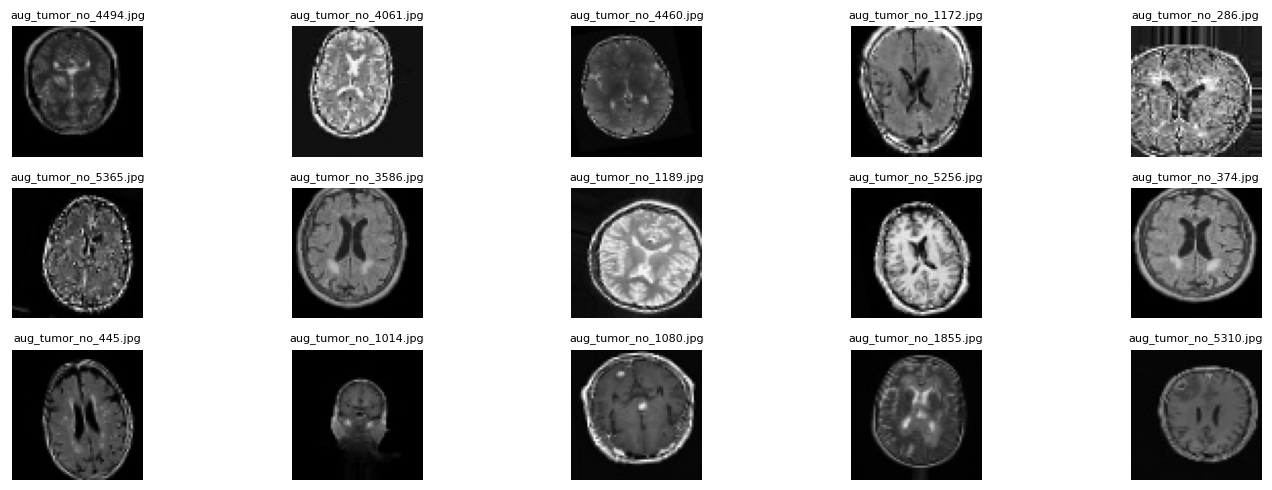

In [10]:
import matplotlib.pyplot as plt
import cv2
import os
import random


augmented_folder = "/content/tumor_alzheimer_dataset/tumor_alzheimer_dataset/tumor_no"


aug_images = [img for img in os.listdir(augmented_folder) if img.startswith("aug_")]

# Show random 15 images for augmentation
sample_imgs = random.sample(aug_images, min(15, len(aug_images)))


plt.figure(figsize=(15, 5))
for idx, img_name in enumerate(sample_imgs):
    img_path = os.path.join(augmented_folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(3, 5, idx + 1)
    plt.imshow(img)
    plt.title(img_name, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


### 2.4.3 - Tumor_YES Augmentation

`from albumentations import (RandomBrightnessContrast, HorizontalFlip, ShiftScaleRotate, GaussianBlur)` This library is more suitable for medical problems. Therefore, this library was preferred for data augmentation in **tumor_yes** data.

```
transform = A.Compose([
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(p=0.3),
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.4),
    GaussianBlur(blur_limit=3, p=0.2)
])
```

*   images were flipped horizontally with a 50% probability. `HorizontalFlip(p=0.5)`
*   Brightness and contrast were adjusted with a 30% probability. `RandomBrightnessContrast(p=0.3)`
*   Images were shifted max ±10%, scaled ±10%, and rotated up to ±20 degrees with a 40% chance. `ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.4)`
*   Slight blur was applied to some images with a 20% probability to simulate mild noise. `GaussianBlur(blur_limit=3, p=0.2)`



In [11]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
import albumentations as A
from albumentations import (
    RandomBrightnessContrast,
    HorizontalFlip,
    ShiftScaleRotate,
    GaussianBlur
)

# ✅ Paths
input_dir = "/content/tumor_alzheimer_dataset/tumor_alzheimer_dataset/tumor_yes"
output_dir = input_dir
target_count = 10000


existing_images = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
current_count = len(existing_images)
needed = target_count - current_count

print(f"📁 Current: {current_count} — Target: {target_count} — Generating: {needed}")

# ✅ Augmentation pipeline
transform = A.Compose([
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(p=0.3),
    ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.4),
    GaussianBlur(blur_limit=3, p=0.2)
])


generated = 0
loop_images = existing_images.copy()
while generated < needed:
    for img_name in tqdm(loop_images, desc="Augmenting"):
        img_path = os.path.join(input_dir, img_name)
        image = cv2.imread(img_path)
        if image is None:
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        augmented = transform(image=image)['image']
        augmented = Image.fromarray(augmented)

        new_name = f"tumor_yes_aug_{generated + 1}.jpg"
        augmented.save(os.path.join(output_dir, new_name))
        generated += 1

        if generated >= needed:
            break

print("The augmentation process is complete.")



📁 Current: 6679 — Target: 10000 — Generating: 3321


Augmenting:  50%|████▉     | 3320/6679 [00:19<00:19, 169.33it/s]

The augmentation process is complete.


#### 2.4.3.1 - Show Augmentation Images

Check new augmentation 15 images randomly. `sample_imgs = random.sample(aug_images, min(15, len(aug_images)))`

In [14]:
import matplotlib.pyplot as plt
import cv2
import os
import random


augmented_folder = "/content/tumor_alzheimer_dataset/tumor_alzheimer_dataset/tumor_yes"


aug_images = [img for img in os.listdir(augmented_folder) if img.startswith("tumor_yes_aug_")]

sample_imgs = random.sample(aug_images, min(15, len(aug_images)))


plt.figure(figsize=(15, 5))
for idx, img_name in enumerate(sample_imgs):
    img_path = os.path.join(augmented_folder, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(3, 5, idx + 1)
    plt.imshow(img)
    plt.title(img_name, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


<Figure size 1500x500 with 0 Axes>

## 2.5 - Show Current Dataset

After the data augmentation, dataset was controlled anc created table which are include label, label name, image count.

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset path
DATASET_DIR = "/content/tumor_alzheimer_dataset/tumor_alzheimer_dataset"


class_names = sorted([folder for folder in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, folder))])

# Count images
class_counts = {cls: len([img for img in os.listdir(os.path.join(DATASET_DIR, cls))
                          if img.lower().endswith(('.jpg', '.jpeg', '.png'))])
                for cls in class_names}

# crate Dataframe
df_distribution = pd.DataFrame(list(class_counts.items()), columns=["Class", "Image Count"])
df_distribution = df_distribution.sort_values("Image Count", ascending=False)

# show table
df_distribution.reset_index(drop=True, inplace=True)
df_distribution


,Class,Image Count
0,alzheimer_non_demented,12800
1,alzheimer_very_mild_demented,11200
2,tumor_yes,10000
3,alzheimer_mild_demented,9856
4,tumor_no,9000
5,alzheimer_moderate_demented,6528


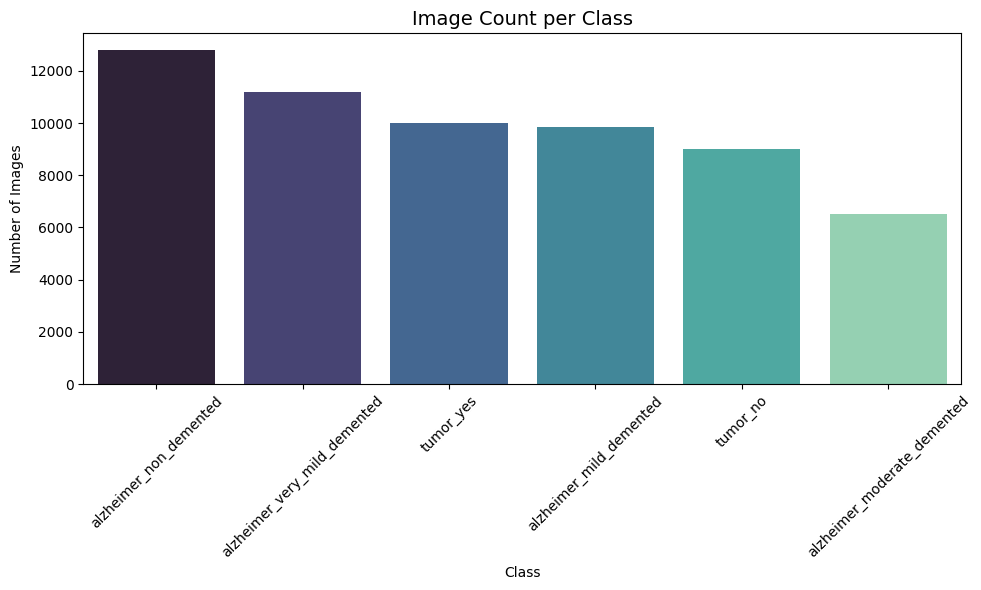

In [16]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_distribution, x="Class", y="Image Count", palette="mako")
plt.title("Image Count per Class", fontsize=14)
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

# **3 - Model Training & Evaluation**

In this section, CNN and ML models are created and compared.

*   Split Data ( Train / Test )
*   CNN Model
*   CNN Model Training
    *   Training Visualization
*   MobileNetV2 - Transfer Learning
*   MobileNetV2 Model Training



## 3.1 - Split the Data (Train / Test)

The train and test datasets are separated by 20%.

In [17]:
from sklearn.model_selection import train_test_split

X = X / 255.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Training Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)

Training Set Shape: (40528, 64, 64, 3)
Test Set Shape: (10133, 64, 64, 3)


## 3.2 - CNN Model

Base cnn was created for first cnn model.


**Model Architecture**

```
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y)), activation='softmax')
])
```


*   `Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3))` Aconvolutional layer with 32 filters of size 3x3 and ReLU activation.
*   `Conv2D(64, (3, 3), activation='relu')` Reduces spatial dimensions.

*   `Flatten()` Converts the 2D feature maps into a 1D vector for dense layers.

*    `Dense(128, activation='relu'),` A fully connected layer with 128 units and ReLU activation.

*     `Dropout(0.5)` Drops 50% of the neurons to prevent overfitting.

**Model Compilation**

```
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
```

*   `optimizer='adam'` In this project the Adam optimization algorithm was preferred. Adam automatically adapts the learning rate for each parameter separately using first and second moment estimates. This leads to faster and more stable convergence during training.



**EarlyStopping**
```
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
```
Stops training if validation accuracy does not improve for 5 consecutive epochs. Recovers the best weights.


**Model Checkpoint**

```
model_checkpoint = ModelCheckpoint(
    filepath='best_cnn_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
```
Saves the model file with the best validation accuracy. The best validation accuracy was saved "**best_cnn_model.h5**" in this cnn model. This checkpoint will be used directly in the later stages of the project. There is no need to retrain the model each time it is run from the beginning.


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np

# CNN Model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y)), activation='softmax')
])

# Compile
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# ✅ Callbacks
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    filepath='best_cnn_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,926 (6.20 MB)

 Trainable params: 1,625,926 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

## 3.3 CNN Model Training

**Time**

```
import time
start = time.time()


end = time.time()
print(f"Training time: {end - start:.2f} seconds")

```
Starts a timer to measure how long model training takes. After the training, stops the timer and prints total training time in seconds.


**Model Training**
```
history_cnn = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)
```



*   `X_train, y_train,` Trains the CNN model using the training data.
*   `epochs=30, batch_size=32` Training was run for 30 epochs, and process 32 images at a time (batch size).
*   `callbacks=[early_stop,` This code can stops training if validation loss doesn’t improve for a few epochs.
*   `callbacks=[  ,model_checkpoint]` Saves the model with the best validation accuracy.
*   `verbose=1` Prints progress of training for each epoch.

In [19]:
import time
start = time.time()

history_cnn = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)

end = time.time()
print(f"⏱️ Training time: {end - start:.2f} seconds")

Epoch 1/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.3573 - loss: 1.4127
Epoch 1: val_accuracy improved from -inf to 0.47084, saving model to best_cnn_model.h5


1267/1267 ━━━━━━━━━━━━━━━━━━━━ 253s 198ms/step - accuracy: 0.3573 - loss: 1.4126 - val_accuracy: 0.4708 - val_loss: 1.1400
Epoch 2/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.4569 - loss: 1.1462
Epoch 2: val_accuracy improved from 0.47084 to 0.56844, saving model to best_cnn_model.h5


1267/1267 ━━━━━━━━━━━━━━━━━━━━ 255s 201ms/step - accuracy: 0.4569 - loss: 1.1462 - val_accuracy: 0.5684 - val_loss: 0.9862
Epoch 3/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.5136 - loss: 1.0377
Epoch 3: val_accuracy improved from 0.56844 to 0.59913, saving model to best_cnn_model.h5


1267/1267 ━━━━━━━━━━━━━━━━━━━━ 253s 200ms/step - accuracy: 0.5136 - loss: 1.0377 - val_accuracy: 0.5991 - val_loss: 0.8758
Epoch 4/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.5549 - loss: 0.9404
Epoch 4: val_accuracy improved from 0.59913 to 0.62657, saving model to best_cnn_model.h5


1267/1267 ━━━━━━━━━━━━━━━━━━━━ 262s 199ms/step - accuracy: 0.5549 - loss: 0.9404 - val_accuracy: 0.6266 - val_loss: 0.7984
Epoch 5/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5838 - loss: 0.8772
Epoch 5: val_accuracy improved from 0.62657 to 0.65055, saving model to best_cnn_model.h5


1267/1267 ━━━━━━━━━━━━━━━━━━━━ 246s 194ms/step - accuracy: 0.5838 - loss: 0.8772 - val_accuracy: 0.6505 - val_loss: 0.7522
Epoch 6/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6001 - loss: 0.8281
Epoch 6: val_accuracy improved from 0.65055 to 0.67256, saving model to best_cnn_model.h5


1267/1267 ━━━━━━━━━━━━━━━━━━━━ 265s 197ms/step - accuracy: 0.6001 - loss: 0.8281 - val_accuracy: 0.6726 - val_loss: 0.7134
Epoch 7/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6119 - loss: 0.8012
Epoch 7: val_accuracy improved from 0.67256 to 0.69150, saving model to best_cnn_model.h5


1267/1267 ━━━━━━━━━━━━━━━━━━━━ 249s 197ms/step - accuracy: 0.6119 - loss: 0.8012 - val_accuracy: 0.6915 - val_loss: 0.6866
Epoch 8/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.6314 - loss: 0.7703
Epoch 8: val_accuracy improved from 0.69150 to 0.70058, saving model to best_cnn_model.h5


1267/1267 ━━━━━━━━━━━━━━━━━━━━ 293s 221ms/step - accuracy: 0.6314 - loss: 0.7703 - val_accuracy: 0.7006 - val_loss: 0.6722
Epoch 9/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.6431 - loss: 0.7468
Epoch 9: val_accuracy improved from 0.70058 to 0.71558, saving model to best_cnn_model.h5


1267/1267 ━━━━━━━━━━━━━━━━━━━━ 303s 206ms/step - accuracy: 0.6431 - loss: 0.7468 - val_accuracy: 0.7156 - val_loss: 0.6245
Epoch 10/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.6553 - loss: 0.7154
Epoch 10: val_accuracy improved from 0.71558 to 0.73275, saving model to best_cnn_model.h5


1267/1267 ━━━━━━━━━━━━━━━━━━━━ 265s 209ms/step - accuracy: 0.6553 - loss: 0.7154 - val_accuracy: 0.7328 - val_loss: 0.6094
Epoch 11/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.6627 - loss: 0.6959
Epoch 11: val_accuracy improved from 0.73275 to 0.73680, saving model to best_cnn_model.h5


1267/1267 ━━━━━━━━━━━━━━━━━━━━ 252s 199ms/step - accuracy: 0.6627 - loss: 0.6959 - val_accuracy: 0.7368 - val_loss: 0.5905
Epoch 12/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.6863 - loss: 0.6633
Epoch 12: val_accuracy improved from 0.73680 to 0.74874, saving model to best_cnn_model.h5


1267/1267 ━━━━━━━━━━━━━━━━━━━━ 289s 221ms/step - accuracy: 0.6863 - loss: 0.6633 - val_accuracy: 0.7487 - val_loss: 0.5559
Epoch 13/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.6866 - loss: 0.6507
Epoch 13: val_accuracy improved from 0.74874 to 0.75634, saving model to best_cnn_model.h5


1267/1267 ━━━━━━━━━━━━━━━━━━━━ 302s 205ms/step - accuracy: 0.6866 - loss: 0.6507 - val_accuracy: 0.7563 - val_loss: 0.5534
Epoch 14/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.6997 - loss: 0.6277
Epoch 14: val_accuracy improved from 0.75634 to 0.76779, saving model to best_cnn_model.h5


1267/1267 ━━━━━━━━━━━━━━━━━━━━ 250s 197ms/step - accuracy: 0.6997 - loss: 0.6277 - val_accuracy: 0.7678 - val_loss: 0.5243
Epoch 15/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.7059 - loss: 0.6201
Epoch 15: val_accuracy improved from 0.76779 to 0.78348, saving model to best_cnn_model.h5


1267/1267 ━━━━━━━━━━━━━━━━━━━━ 279s 220ms/step - accuracy: 0.7059 - loss: 0.6201 - val_accuracy: 0.7835 - val_loss: 0.5183
Epoch 16/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.7183 - loss: 0.5979
Epoch 16: val_accuracy did not improve from 0.78348
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 299s 202ms/step - accuracy: 0.7183 - loss: 0.5979 - val_accuracy: 0.7758 - val_loss: 0.5113
Epoch 17/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.7231 - loss: 0.5843
Epoch 17: val_accuracy improved from 0.78348 to 0.78476, saving model to best_cnn_model.h5


1267/1267 ━━━━━━━━━━━━━━━━━━━━ 256s 202ms/step - accuracy: 0.7231 - loss: 0.5843 - val_accuracy: 0.7848 - val_loss: 0.4941
Epoch 18/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.7276 - loss: 0.5768
Epoch 18: val_accuracy improved from 0.78476 to 0.79542, saving model to best_cnn_model.h5


1267/1267 ━━━━━━━━━━━━━━━━━━━━ 267s 211ms/step - accuracy: 0.7276 - loss: 0.5768 - val_accuracy: 0.7954 - val_loss: 0.4757
Epoch 19/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.7304 - loss: 0.5649
Epoch 19: val_accuracy improved from 0.79542 to 0.81170, saving model to best_cnn_model.h5


1267/1267 ━━━━━━━━━━━━━━━━━━━━ 269s 212ms/step - accuracy: 0.7304 - loss: 0.5649 - val_accuracy: 0.8117 - val_loss: 0.4624
Epoch 20/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.7462 - loss: 0.5486
Epoch 20: val_accuracy did not improve from 0.81170
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 324s 214ms/step - accuracy: 0.7462 - loss: 0.5486 - val_accuracy: 0.8031 - val_loss: 0.4681
Epoch 21/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7457 - loss: 0.5367
Epoch 21: val_accuracy improved from 0.81170 to 0.82295, saving model to best_cnn_model.h5


1267/1267 ━━━━━━━━━━━━━━━━━━━━ 342s 229ms/step - accuracy: 0.7457 - loss: 0.5367 - val_accuracy: 0.8230 - val_loss: 0.4324
Epoch 22/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.7504 - loss: 0.5216
Epoch 22: val_accuracy improved from 0.82295 to 0.83124, saving model to best_cnn_model.h5


1267/1267 ━━━━━━━━━━━━━━━━━━━━ 303s 214ms/step - accuracy: 0.7504 - loss: 0.5215 - val_accuracy: 0.8312 - val_loss: 0.4184
Epoch 23/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.7588 - loss: 0.5128
Epoch 23: val_accuracy did not improve from 0.83124
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 329s 220ms/step - accuracy: 0.7588 - loss: 0.5128 - val_accuracy: 0.8216 - val_loss: 0.4338
Epoch 24/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.7604 - loss: 0.5071
Epoch 24: val_accuracy improved from 0.83124 to 0.83450, saving model to best_cnn_model.h5


1267/1267 ━━━━━━━━━━━━━━━━━━━━ 326s 257ms/step - accuracy: 0.7604 - loss: 0.5071 - val_accuracy: 0.8345 - val_loss: 0.4087
Epoch 25/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7675 - loss: 0.4949
Epoch 25: val_accuracy did not improve from 0.83450
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 347s 230ms/step - accuracy: 0.7675 - loss: 0.4949 - val_accuracy: 0.8264 - val_loss: 0.4334
Epoch 26/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.7755 - loss: 0.4875
Epoch 26: val_accuracy improved from 0.83450 to 0.83914, saving model to best_cnn_model.h5


1267/1267 ━━━━━━━━━━━━━━━━━━━━ 280s 221ms/step - accuracy: 0.7755 - loss: 0.4875 - val_accuracy: 0.8391 - val_loss: 0.4003
Epoch 27/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.7785 - loss: 0.4768
Epoch 27: val_accuracy improved from 0.83914 to 0.84427, saving model to best_cnn_model.h5


1267/1267 ━━━━━━━━━━━━━━━━━━━━ 313s 214ms/step - accuracy: 0.7785 - loss: 0.4768 - val_accuracy: 0.8443 - val_loss: 0.4049
Epoch 28/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.7844 - loss: 0.4684
Epoch 28: val_accuracy did not improve from 0.84427
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 257s 203ms/step - accuracy: 0.7844 - loss: 0.4684 - val_accuracy: 0.8431 - val_loss: 0.3953
Epoch 29/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.7856 - loss: 0.4638
Epoch 29: val_accuracy improved from 0.84427 to 0.84881, saving model to best_cnn_model.h5


1267/1267 ━━━━━━━━━━━━━━━━━━━━ 254s 196ms/step - accuracy: 0.7856 - loss: 0.4638 - val_accuracy: 0.8488 - val_loss: 0.3841
Epoch 30/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.7886 - loss: 0.4587
Epoch 30: val_accuracy improved from 0.84881 to 0.85187, saving model to best_cnn_model.h5


1267/1267 ━━━━━━━━━━━━━━━━━━━━ 249s 196ms/step - accuracy: 0.7886 - loss: 0.4587 - val_accuracy: 0.8519 - val_loss: 0.3902
Restoring model weights from the end of the best epoch: 30.
⏱️ Training time: 8450.04 seconds


### 3.3.1 Training Visualization

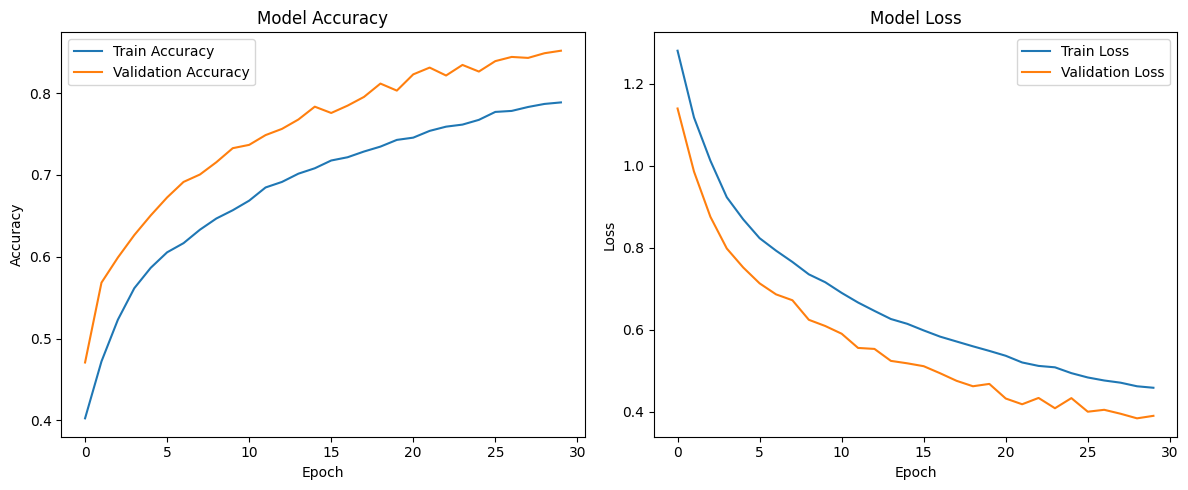

In [23]:
import matplotlib.pyplot as plt

# Accuracy grafiği
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## 3.4 - MobileNetV2 - Transfer Learning

In [28]:
import time
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam


input_shape = (64, 64, 3)

# Base model
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)

# Transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Add new layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(6, activation='softmax')(x)

# Create Model
mobilenet_model = Model(inputs=base_model.input, outputs=outputs)


mobilenet_model.compile(optimizer=Adam(learning_rate=0.0001),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])


early_stop = EarlyStopping(
                           monitor='val_loss',
                           patience=5,
                           restore_best_weights=True,
                           verbose=1
)

checkpoint = ModelCheckpoint(
    filepath="best_mobilenetv2_model.keras",
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)


mobilenet_model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 32, 32, 32)     │            864 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 32, 32, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 32, 32, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 32, 32, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 32, 32, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 32, 32, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 32, 32, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 32, 32, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 32, 32, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 32, 32, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 32, 32, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 33, 33, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 16, 16, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,587,462 (9.87 MB)

 Trainable params: 329,478 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 3.5 - MobileNetV2 Model Training

In [29]:
import time

start_time = time.time()

# Modeli eğit
history_mobilenet = mobilenet_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time:.2f} seconds")


Epoch 1/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.2663 - loss: 1.8393
Epoch 1: val_accuracy improved from -inf to 0.36741, saving model to best_mobilenetv2_model.keras
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 188s 143ms/step - accuracy: 0.2663 - loss: 1.8391 - val_accuracy: 0.3674 - val_loss: 1.4175
Epoch 2/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.3594 - loss: 1.4127
Epoch 2: val_accuracy improved from 0.36741 to 0.38212, saving model to best_mobilenetv2_model.keras
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 182s 143ms/step - accuracy: 0.3594 - loss: 1.4127 - val_accuracy: 0.3821 - val_loss: 1.3152
Epoch 3/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.3665 - loss: 1.3324
Epoch 3: val_accuracy did not improve from 0.38212
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 194s 153ms/step - accuracy: 0.3665 - loss: 1.3324 - val_accuracy: 0.3797 - val_loss: 1.2799
Epoch 4/30
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.3760 - loss: 1.3041
Epoch 4: val_accuracy